In [24]:
'''Commented algorithm are available separetly'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
from scipy.ndimage.filters import laplace
from scipy.ndimage import convolve
import scipy.stats as st
from scipy.signal import correlate2d
from numpy.linalg import svd, inv
import collections
%matplotlib inline

In [28]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def P2R(radii, angles):
    return radii * np.exp(1j*angles)

def R2P(x):
    return np.abs(x), np.angle(x)

def LaplacianInterriorDomain(Image):
    M=len(Image)
    N=len(Image[0])
    u=np.copy(Image)
    DeltaU=laplace(u)
    v1=np.zeros([M,N])
    v2=np.zeros([M,N])
    for y in range(N):
        v1[0,y]=u[M-1,y]-u[0,y]
        v1[M-1,y]=u[0,y]-u[M-1,y]
    for x in range(M):
        v2[x,0]=u[x,N-1]-u[x,0]
        v2[x,N-1]=u[x,0]-u[x,N-1]
    v=v1+v2
    DeltaU_V=DeltaU-v
    return(DeltaU_V)

def CenterRGB(im):
    rgb=np.copy(im)
    rgb[:,:,0]=rgb[:,:,0]-np.mean(rgb[:,:,0].ravel())
    rgb[:,:,1]=rgb[:,:,1]-np.mean(rgb[:,:,1].ravel())
    rgb[:,:,2]=rgb[:,:,2]-np.mean(rgb[:,:,2].ravel())
    return(np.array(rgb[:,:,0:3],dtype=np.float))

def RelocateRGB(Centered,rgb):
    Centered[:,:,0]=Centered[:,:,0]+np.mean(rgb[:,:,0].ravel())
    Centered[:,:,1]=Centered[:,:,1]+np.mean(rgb[:,:,1].ravel())
    Centered[:,:,2]=Centered[:,:,2]+np.mean(rgb[:,:,2].ravel())
    return(np.array(Centered[:,:,0:3],dtype=np.float))

def FlatArray(a):
    return(np.array([a[:,:,0].ravel(),a[:,:,1].ravel(),a[:,:,2].ravel()]).transpose())
    
def ExpandArray(a,L0,L1):
    NewArray=np.zeros([L0,L1,3])
    NewArray[:,:,0]=np.reshape(a[:,0],[L0,L1])
    NewArray[:,:,1]=np.reshape(a[:,1],[L0,L1])
    NewArray[:,:,2]=np.reshape(a[:,2],[L0,L1])
    return NewArray

def SVDmatrices(img):
    a=CenterRGB(img)
    a2=np.array([a[:,:,0].ravel(),a[:,:,1].ravel(),a[:,:,2].ravel()])
    c=np.dot(a2,a2.transpose())
    U,s,V=svd(c)
    s=np.sqrt(s)
    M=np.dot(np.diag(np.divide(np.ones_like(s),s)),np.transpose(U))
    Minv=inv(M)
    return (Minv,M)

def DeCorrelate(imgFlat,M):
    DeCorr=np.zeros_like(imgFlat,dtype=np.float)
    for i in range(len(imgFlat)):
        DeCorr[i,:]=np.dot(imgFlat[i,:],M)
    return DeCorr

def ReCorrelate(imgFlat,Minv):
    Transformed=np.zeros_like(imgFlat,dtype=np.float)
    for i in range(len(imgFlat)):
        Transformed[i,:]=np.dot(imgFlat[i,:],Minv)
    return Transformed

def Crop(Image):
    L=len(Image)
    l=len(Image[0])
    SizeL=np.int(np.log2(L))
    Sizel=np.int(np.log2(l))
    if 2**SizeL==L and 2**Sizel == l:
        return Image
    else:
        Side=min([SizeL,Sizel])
        Cropped=np.zeros([2**Side,2**Side,3])
        Cropped[:]=Image[int(L/2)-2**(Side-1):int(L/2)+2**(Side-1),int(l/2)-2**(Side-1):int(l/2)+2**(Side-1),:]
        return Cropped
    
    
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def Reduce(data):
    b=SubSample(LowPassFilter(data))
    return b

def Expand(data):
    l=LowPassFilter(UpSample(data))
    return l

def SubSample(data):
    Size=np.array(data.shape,dtype=np.int)/2
    return data[0::2,0::2]

def UpSample(data):
    Size=np.array(data.shape,dtype=np.int)*2
    UpSampled=np.zeros(Size)
    UpSampled[0::2,0::2]=data[:,:]
    return UpSampled

def LowPassFilter(data):
    Sfilter=2
    Filter2D=np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])*1/256.0
#     Filter2D=np.array([[1,-1,1],[0,0,0],[1,-1,1]])/2
    Result=convolve(data, Filter2D, mode='wrap')
    return(Result)

class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = collections.defaultdict(list)
        self.distances = {}

    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.distances[(from_node, to_node)] = distance
    
    def Matrix2Graph(self,Matrix):
        Copy=Matrix.ravel()
        L=len(Matrix)
        l=len(Matrix[0])
        for i in range(len(Copy)):
            self.add_node(i)
        self.add_node(len(Copy))
        self.add_node(len(Copy)+1)
        for i in range(L):
            for j in range(l):
                if j==l-1 and i==L-1:
                    self.add_edge(i*l+j,len(Copy)+1,0)
                    self.add_edge(len(Copy)+1,i*l+j,Matrix[i,j])
                    break
                elif i==L-1:
                    self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                    self.add_edge(i*l+j,len(Copy)+1,0)
                    self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                    self.add_edge(len(Copy)+1,i*l+j,Matrix[i,j])
                elif j==l-1:
                    if i==0:
                        self.add_edge(i*l+j,len(Copy),0)
                        self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                    self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                    self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                    self.add_edge(i*l+j,(i+1)*l+j-1,Matrix[i+1,j-1])
                    self.add_edge((i+1)*l+j-1,i*l+j,Matrix[i,j])
                else:
                    if j==0:
                        if i==0:
                            self.add_edge(i*l+j,len(Copy),0)
                            self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                        self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                        self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j+1,Matrix[i+1,j+1])
                        self.add_edge((i+1)*l+j+1,i*l+j,Matrix[i,j])
                    
                    else:
                        if i==0:
                            self.add_edge(i*l+j,len(Copy),0)
                            self.add_edge(len(Copy),i*l+j,Matrix[i,j])

                        self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                        self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                        self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j+1,Matrix[i+1,j+1])
                        self.add_edge(i*l+j,(i+1)*l+j-1,Matrix[i+1,j-1])
                        self.add_edge((i+1)*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge((i+1)*l+j-1,i*l+j,Matrix[i,j])
        
    
def dijsktra(graph, initial):
    visited = {initial: 0}
    path = {}

    nodes = set(graph.nodes)
    while nodes: 
        min_node = None
        for node in nodes:
            if node in visited:
                if min_node is None:
                    min_node = node
                elif visited[node] < visited[min_node]:
                    min_node = node

        if min_node is None:
            break

        nodes.remove(min_node)
        current_weight = visited[min_node]

        for edge in graph.edges[min_node]:
            weight = current_weight + graph.distances[(min_node, edge)]
            if edge not in visited or weight < visited[edge]:
                visited[edge] = weight
                path[edge] = min_node

    return visited, path

def BackTrack(path,TileSize,overlap):
    i=TileSize*overlap
    i=path[i]
    optP=[]
    while(i<TileSize*overlap+1):
        optP.append(i)
        i=path[i]
    return optP

class PyramidNode:
    def __init__(self,data):
        self.data=data
    def updateData(self,newdata):
        self.data=newdata

class Pyramid:
    def __init__(self,img):
        self.img=img
        self.depth=0
        self.Llist=[PyramidNode(Reduce(img))]
        self.Blist=[PyramidNode(img-Expand(self.Llist[0].data))]
        self.size=np.array(self.Llist[0].data.shape)

    def makePyramid(self,loop):
        for i in range(loop):
            self.Llist.append(PyramidNode(Reduce((self.Llist[self.depth]).data)))
            self.Blist.append(PyramidNode(self.Llist[self.depth].data-Expand(self.Llist[self.depth+1].data)))
            self.depth=self.depth+1

    def getL(self,level):
        if level<=self.depth:
            return(self.Llist[level].data)
        else:
            return 0

    def getB(self,level):
        if level<=self.depth:
            return(self.Blist[level].data)
        else:
            return 0
    
    def updateL(self,level,data):
        self.Llist[level].updateData(data)
        
    def updateB(self,level,data):
        self.Blist[level].updateData(data)
    
    def CollapsePyramid(self):
        for i in range(self.depth,0,-1):
            self.updateL(i-1,Expand(self.getL(i))+self.getB(i))
        return Expand(self.getL(0))+self.getB(0)

def MatchHistogram(Noise,Sample):
    M=len(Noise)
    N=len(Noise[0])
    BaseImRavel=np.copy(Sample).ravel()
    NoiseImRavel=np.copy(Noise).ravel()
    BaseSorted=np.argsort(BaseImRavel)
    NoiseSorted=np.argsort(NoiseImRavel)
    for i in range(M*N):
        NoiseImRavel[NoiseSorted[i]]=BaseImRavel[BaseSorted[i]]
    return np.reshape(NoiseImRavel,[M,N])

def MatchTexture(noise,texture,depth=5,loop=5):
    noise=MatchHistogram(noise,texture)
    PyrText=Pyramid(texture)
    PyrText.makePyramid(depth)
    for i in range(loop):
        PyrNoise=Pyramid(noise)
        PyrNoise.makePyramid(depth)
        for j in range(depth):
            PyrNoise.updateB(j,MatchHistogram(PyrNoise.getB(j),
                                              PyrText.getB(j)))
        noise=PyrNoise.CollapsePyramid()
    noise=MatchHistogram(noise,texture)
    return noise

def DensityColor(image,depth=2,loop=5):
    Cropped=Crop(image)
    Centered=CenterRGB(Cropped)
    L=Centered.shape
    L0=L[0]
    L1=L[1]
    M, Minv = SVDmatrices(Centered)
    imageFl=FlatArray(Centered)
    noiseRed=np.random.rand(L0, L1)
    noiseGreen=np.random.rand(L0, L1)
    noiseBlue=np.random.rand(L0, L1)
    imDeCorr=DeCorrelate(imageFl,M)
    imDeCorr=ExpandArray(imDeCorr,L0,L1)
    NoiseRed=MatchTexture(noiseRed,imDeCorr[:,:,0],depth,loop)
    NoiseGreen=MatchTexture(noiseGreen,imDeCorr[:,:,1],depth,loop)
    NoiseBlue=MatchTexture(noiseBlue,imDeCorr[:,:,2],depth,loop)
    Noise=np.zeros([L0,L1,3])
    Noise[:,:,0]=np.reshape(NoiseRed,[L0,L1])
    Noise[:,:,1]=np.reshape(NoiseGreen,[L0,L1])
    Noise[:,:,2]=np.reshape(NoiseBlue,[L0,L1])
    NoiseFl=FlatArray(Noise)
    RecorrelateImage=ReCorrelate(NoiseFl,Minv)
    Recentered=RelocateRGB(ExpandArray(RecorrelateImage,L0,L1),Cropped)
    Recentered[Recentered<0]=0
    Recentered[Recentered>1]=0.999
    return Recentered

def GetSeed(Image):
    Size=Image.shape
    cx=randint(2,Size[0]-2)
    cy=randint(2,Size[1]-2)
    Seed=Image[cx-1:cx+2,cy-1:cy+2,:]*.99
    return(Seed)

def Image2Fill(SizeX,SizeY,Image):
    seed=GetSeed(Image)
    NewImage = np.empty([SizeX,SizeY,3])
    NewImage.fill(np.nan)
    NewImage[int(SizeX/2)-1:int(SizeX/2)+2,int(SizeY/2)-1:int(SizeY/2)+2]=seed
    return NewImage

def ComputeDistance(CurrentPatch,RefPatch,GKernel):
    Mask=~np.logical_and(~np.isnan(CurrentPatch),~np.isnan(RefPatch))
    RefPatch2=np.copy(RefPatch)
    CurrentPatch[Mask]=np.nan
    RefPatch2[Mask]=np.nan
    if (np.sum(~Mask*1)<6):
#         plt.imshow(RefPatch)
#         plt.show()
        return 100
    else:
        DistR=np.nansum(np.square(CurrentPatch[:,:,0]-RefPatch[:,:,0])*GKernel)/np.sum(GKernel[~Mask[:,:,0]])*0.2989
        DistG=np.nansum(np.square(CurrentPatch[:,:,1]-RefPatch[:,:,1])*GKernel)/np.sum(GKernel[~Mask[:,:,0]])*0.5870
        DistB=np.nansum(np.square(CurrentPatch[:,:,2]-RefPatch[:,:,2])*GKernel)/np.sum(GKernel[~Mask[:,:,0]])*0.1140
        return DistR+DistG+DistB

def GetUnfilledNeigbors(NewImage):
    Size=np.array(NewImage.shape)
    Size[0]=Size[0]-2
    Size[1]=Size[1]-2
    Neighbors=np.zeros([Size[0]*Size[1],3],dtype=int)
    ind=0
    for i in range(1,Size[0]+1):
        for j in range(1,Size[1]+1):
            Neighbors[ind,1]=i
            Neighbors[ind,2]=j
            if ~np.isnan(NewImage[i,j,0]):
                Neighbors[ind,0]=-1
            else:
                Patch=NewImage[i-1:i+2,j-1:j+2,0]
                Patch[1,1]=np.nan
                Neighbors[ind,0]=np.sum(~np.isnan(Patch))
            ind=ind+1
    return Neighbors

def Distance(WindowSize,Image,NewImage,Sigma,Pixelx,Pixely):
    SizeNewImage=np.array(NewImage.shape)
    SizeImage=np.array(Image.shape)
    GKernel=gkern(WindowSize, Sigma)
    DistMat=np.ones_like(Image[:,:,0])*100
    
    RefPatch=np.empty([WindowSize,WindowSize,3])
    RefPatch.fill(np.nan)
    minxNew=np.max([0,Pixelx-int(WindowSize/2)])
    minyNew=np.max([0,Pixely-int(WindowSize/2)])
    maxxNew=np.min([SizeNewImage[0],Pixelx+int(WindowSize/2)])
    maxyNew=np.min([SizeNewImage[1],Pixely+int(WindowSize/2)])

    xmPatchRef=np.max([int(WindowSize/2)-Pixelx,0])
    xMPatchRef=np.min([WindowSize,SizeNewImage[0] + int(WindowSize/2) - Pixelx])
    ymPatchRef=np.max([int(WindowSize/2)-Pixely,0])
    yMPatchRef=np.min([WindowSize,SizeNewImage[1] + int(WindowSize/2) - Pixely])
    RefPatch[xmPatchRef:xMPatchRef,ymPatchRef:yMPatchRef,:]= NewImage[minxNew:maxxNew+1,minyNew:maxyNew+1,:]
    
    for i in range(int(WindowSize/2),SizeImage[0]+1-int(WindowSize/2)):
        for j in range(int(WindowSize/2),SizeImage[1]+1-int(WindowSize/2)):
            xmPatch=np.max([int(WindowSize/2)-i,0])
            xMPatch=np.min([WindowSize,SizeImage[0] + int(WindowSize/2) - i])
            ymPatch=np.max([int(WindowSize/2)-j,0])
            yMPatch=np.min([WindowSize,SizeImage[1] + int(WindowSize/2) - j])
            minx=i-int(WindowSize/2)
            miny=j-int(WindowSize/2)
            maxx=i+int(WindowSize/2)
            maxy=j+int(WindowSize/2)
            CurrentPatch=np.empty([WindowSize,WindowSize,3])
            CurrentPatch.fill(np.nan)
            CurrentPatch[xmPatch:xMPatch,ymPatch:yMPatch,:]=Image[minx:maxx+1,miny:maxy+1,:]
            dist=ComputeDistance(CurrentPatch,RefPatch,GKernel)
            DistMat[i][j]=dist
    return DistMat

def NonParamColor(WindowSize,SizeX,SizeY,Image):
    Threshold=0.1
    Sigma=WindowSize/6.4
    MaxErrorThresh=0.3
    
    NewImage=Image2Fill(SizeX,SizeY,Image)
    Neighbors=GetUnfilledNeigbors(NewImage)
    count=0
    while(sum((Neighbors[:,0]>0)*1)>0):
        progress=0
        posNei=np.argmax(Neighbors,0)[0]
        posNei=Neighbors[posNei,:]
        Pixelx=posNei[1]
        Pixely=posNei[2]
        Dist=Distance(WindowSize,Image,NewImage,Sigma,Pixelx,Pixely)
        indicesDist=np.array(np.where(Dist<=(np.min(Dist)*(1+Threshold))))
        randind=randint(0,len(indicesDist[0])-1)
        if Dist[indicesDist[0,randind],indicesDist[1,randind]] < MaxErrorThresh:
            IndiceImage=[indicesDist[0,randind],indicesDist[1,randind]]
            NewImage[Pixelx,Pixely,:]=Image[IndiceImage[0],IndiceImage[1],:]
            progress=1
        if progress  == 0:
            MaxErrorThresh=MaxErrorThresh*1.1
        count=count+1
        Neighbors=GetUnfilledNeigbors(NewImage)
    return NewImage[1:-1,1:-1]

def RandomPatches(Image,TileSize,Sout):
    S0in=Image.shape[0]
    S1in=Image.shape[1]
    Output=np.zeros([Sout,Sout])
    for i in range(0,Sout-TileSize+1,TileSize):
        for j in range(0,Sout-TileSize+1,TileSize):
            pos = [randint(0,S0in-TileSize-1),randint(0,S1in-TileSize-1)]
            Output[i:i+TileSize,j:j+TileSize]=Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize]
    return Output

def FindErrorHorz(ImageHorz,Patch,TileSize,overlap):
    errLoop=np.zeros([ImageHorz.shape[0]-TileSize,len(ImageHorz[0])-TileSize])
    for i in range(len(ImageHorz)-TileSize):
        for j in range(len(ImageHorz[0])-TileSize):
            errR=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap,0]-Patch[:,:,0]))
            errG=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap,1]-Patch[:,:,1]))
            errB=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap,2]-Patch[:,:,2]))
            errLoop[i,j]=0.2989*errR+ 0.5870*errG+ 0.1140*errB
    return errLoop

def rotate90(Matrix):
    Rotated=np.zeros([len(Matrix[0]),len(Matrix),3],dtype=np.float)
    for i in range(len(Matrix[0])):
        Rotated[i,:,:]=Matrix[:,len(Matrix[0])-i-1,:]
    return(Rotated)

def ShortestHorz(Oold,Pnew,overlap):
    TileSize=len(Pnew)
    Onew=Pnew[0:TileSize,0:overlap,:]
    SSD=0.2989*np.square(Oold[:,:,0]-Onew[:,:,0])+0.5870*np.square(Oold[:,:,0]-Onew[:,:,0])
    +0.1140*np.square(Oold[:,:,0]-Onew[:,:,0])
    g = Graph()
    g.Matrix2Graph(SSD)
    v,p=dijsktra(g,TileSize*overlap+1)
    path=BackTrack(p,TileSize,overlap)
    path = np.array(np.unravel_index(path, [TileSize,overlap])).transpose()
    b=np.copy(SSD)
    for i in range(len(path)):
        b[path[i,0],path[i,1]]=np.nan
    cut=np.zeros([TileSize],dtype=np.int)
    for i in range(TileSize):
        PosCut=path[path[:,0]==i,:][0][1]
        PosCut=np.min(PosCut)
        cut[i]=PosCut
    return cut

def FindErrorVert(ImageVert,Patch,TileSize,overlap):
    errLoop=np.zeros([ImageVert.shape[0]-TileSize,len(ImageVert[0])-TileSize])
    for i in range(len(ImageVert)-TileSize):
        for j in range(len(ImageVert[0])-TileSize):
            errR=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize,0]-Patch[:,:,0]))
            errG=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize,1]-Patch[:,:,1]))
            errB=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize,2]-Patch[:,:,2]))
            errLoop[i,j]=0.2989*errR+ 0.5870*errG+ 0.1140*errB
    return errLoop

def FindErrorL(ImageL,OverlapHorz,OverlapVert,TileSize,overlap):
    Image=np.copy(ImageL)
    errLoop=np.zeros([Image.shape[0]-TileSize,len(Image[0])-TileSize])
    for i in range(len(Image)-TileSize):
        for j in range(len(Image[0])-TileSize):
            ErrHorzR=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap,0]-OverlapHorz[:,:,0]))
            ErrHorzG=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap,1]-OverlapHorz[:,:,1]))
            ErrHorzB=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap,2]-OverlapHorz[:,:,2]))
            ErrVertR=np.sum(np.square(Image[i:i+overlap,j:j+TileSize,0]-OverlapVert[:,:,0]))
            ErrVertG=np.sum(np.square(Image[i:i+overlap,j:j+TileSize,1]-OverlapVert[:,:,1]))
            ErrVertB=np.sum(np.square(Image[i:i+overlap,j:j+TileSize,2]-OverlapVert[:,:,2]))
            ErrHorz=0.2989*ErrHorzR+ 0.5870*ErrHorzG+ 0.1140*ErrHorzB
            ErrVert=0.2989*ErrVertR+ 0.5870*ErrVertG+ 0.1140*ErrVertB
            errLoop[i,j]=ErrHorz+ErrVert
    return errLoop

def PickPatch(ErrorMat,Image,TileSize,overlap,eps=1.1):
    index=np.where(ErrorMat<=1.1*np.min(ErrorMat.ravel()))
    c=randint(0,len(index[0])-1)
    pos=[index[0][c],index[1][c]]
    NewPatch=np.copy(Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize,:])
    return NewPatch

def QuiltingColor(Image,TileSize,overlap,S0out,S1out):
    S0in=Image.shape[0]
    S1in=Image.shape[1]
    Output=np.zeros([S0out,S1out,3],np.float)
    ImHorz=Image[:,TileSize-overlap:,:]
    ImVert=Image[TileSize-overlap:,:,:]
    ImL=Image[TileSize-overlap:,TileSize-overlap:,:]
    for i in range(0,S0out-TileSize+1,TileSize-overlap):
        for j in range(0,S1out-TileSize+1,TileSize-overlap):
            if i==0 and j==0:
                pos = [randint(0,S0in-TileSize-1),randint(0,S1in-TileSize-1)]
                NPatch=Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize,:]
            elif i==0:
                #Overlap horizontal
                OverlappingRegion=Output[i:i+TileSize,j:j+overlap,:]
                ErrHorz=FindErrorHorz(ImHorz,OverlappingRegion,TileSize,overlap)
                NPatch=PickPatch(ErrHorz,ImHorz,TileSize,overlap)
                cut=ShortestHorz(OverlappingRegion,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlappingRegion[k,0:cut[k],:]
                
            elif j==0:
                OverlappingRegion=Output[i:i+overlap,j:j+TileSize,:]
                ErrVert=FindErrorVert(ImVert,OverlappingRegion,TileSize,overlap)                
                NPatch=PickPatch(ErrVert,ImVert,TileSize,overlap)
                NPatch=rotate90(NPatch)
                OverlappingRegion=rotate90(OverlappingRegion)
                cut=ShortestHorz(OverlappingRegion,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlappingRegion[k,0:cut[k],:]
                NPatch=rotate90(rotate90(rotate90(NPatch)))
            else:
                OverlapHorz=Output[i+overlap:i+TileSize,j:j+overlap,:]
                OverlapVert=Output[i:i+overlap,j:j+TileSize,:]
                ErrL=FindErrorL(ImL,OverlapHorz,OverlapVert,TileSize,overlap)
                NPatch=PickPatch(ErrL,ImL,TileSize,overlap)
                OverlapHorz=Output[i:i+TileSize,j:j+overlap]
                cut=ShortestHorz(OverlapHorz,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlapHorz[k,0:cut[k],:]
                NPatch=rotate90(NPatch)
                OverlapVert=rotate90(OverlapVert)
                cut=ShortestHorz(OverlapVert,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlapVert[k,0:cut[k],:]
                NPatch=rotate90(rotate90(rotate90(NPatch)))
#             plt.imshow(NPatch)
#             plt.show()
            Output[i:i+TileSize,j:j+TileSize,:]=NPatch
    return Output[:TileSize+int((S0out-TileSize)/(TileSize-overlap))*(TileSize-overlap),
                  :TileSize+int((S1out-TileSize)/(TileSize-overlap))*(TileSize-overlap),:]

def AddNoise(Image,Noise):
    ImageFFT=(np.fft.fft2(Image))
    norm, phase = R2P(ImageFFT)
    NImageFFT=P2R(norm,phase+Noise)
    return((np.abs(np.fft.ifft2(NImageFFT))))

def GenerateNoise(Image):
    RandomPhase=np.random.rand(len(Image),len(Image[0]))*2*math.pi-np.ones([len(Image),len(Image[0])])*math.pi
    return RandomPhase

def RPN(Image):
    Noise=GenerateNoise(Image)
    NewImage=np.zeros(Image.shape)
    NewImage[:,:,0]=AddNoise(Image[:,:,0],Noise)
    NewImage[:,:,1]=AddNoise(Image[:,:,1],Noise)
    NewImage[:,:,2]=AddNoise(Image[:,:,2],Noise)
    return(NewImage)

def PeriodicComponent(Image):
    M=len(Image)
    N=len(Image[0])
    Lap=LaplacianInterriorDomain(Image)
    LapFFT=np.fft.fft2(Lap)
    PFFT=np.zeros([M,N],dtype=np.complex)
    PFFT2=np.copy(LapFFT)
    cosi=np.tile(np.arange(0,M,dtype=np.float)*2*math.pi/M,[N,1])
    cosj=np.tile(np.arange(0,N,dtype=np.float)*2*math.pi/N,[M,1]).transpose()
    cosi[0,0]=1
    temp=2*np.cos(cosi)+2*np.cos(cosj)-np.ones([M,N])*4
    PFFT2=np.divide(PFFT2,temp)
    PFFT2[0,0]=np.sum(np.ravel(Image))
    P=np.fft.ifft2(PFFT2)
    return(P)

def RPNColor(Image,S0,S1):
    M=len(Image)
    N=len(Image[0])
    mR=np.mean(Image[:,:,0].ravel())
    mG=np.mean(Image[:,:,1].ravel())
    mB=np.mean(Image[:,:,2].ravel())
    PR=np.abs(PeriodicComponent(Image[:,:,0]))
    PG=np.abs(PeriodicComponent(Image[:,:,1]))
    PB=np.abs(PeriodicComponent(Image[:,:,2]))
    Texture=np.ones([S0,S1,3])
    Texture[:,:,0]=Texture[:,:,0]*mR
    Texture[:,:,1]=Texture[:,:,1]*mG
    Texture[:,:,2]=Texture[:,:,2]*mB
    
    #Get center as integers since the division in Python 3 of two integers is not an integer 
    S02 = int(S0/2)
    M2 = int(M/2)
    S12 = int(S1/2)
    N2 = int(N/2)
    
    #Placing the periodic component at the center, the periodic component as its variance normalized
    Texture[(S02-M2):(S02-M2+M),(S12-N2):(S12-N2+N),0]=(PR-mR*np.ones([M,N]))*np.sqrt(S0*S1/(M*N))+mR*np.ones([M,N])
    Texture[(S02-M2):(S02-M2+M),(S12-N2):(S12-N2+N),1]=(PG-mG*np.ones([M,N]))*np.sqrt(S0*S1/(M*N))+mG*np.ones([M,N])
    Texture[(S02-M2):(S02-M2+M),(S12-N2):(S12-N2+N),2]=(PB-mB*np.ones([M,N]))*np.sqrt(S0*S1/(M*N))+mB*np.ones([M,N])
    
    R=RPN(Texture)
    R[R<0]=0
    R[R>1]=0.99999
    return R

In [29]:
''' All the input images have to be in [0,1],
For all format expect .png dividing by 256.0 is necessary
Example:
img=np.array(mpimg.imread('../Samples/161.gif')[:,:,:3]/256.0)
'''
img=np.array(mpimg.imread('../Samples/Wall.jpg')[:,:,:3]/255.0)

In [30]:
'''NonParamColor is really slow and using it on big textures is not a good idea'''
# %%snakeviz
RPNTexture=RPNColor(Image=img,S0=280,S1=280)
QuiltedTexture=QuiltingColor(img,40,6,500,500)
NonParamTexture=NonParamColor(WindowSize=13,SizeX=10,SizeY=10,Image=img)
DensityTexture=DensityColor(image=img,depth=6,loop=10)

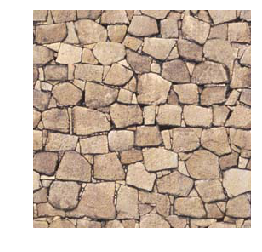

In [22]:
plt.imshow(img)
plt.axis('off')
plt.show()

# plt.imshow(QuiltedTexture,cmap='gray',interpolation='none')
# plt.axis('off')
# plt.savefig('./Results/QuiltingWallLarge.png',bbox_inches='tight',dpi=300)
# plt.show()

# plt.imshow(NonParamTexture,cmap='gray')
# plt.axis('off')
# # plt.savefig('NonParamYog.png',bbox_inches='tight',dpi=300)
# plt.show()

# plt.imshow(DensityTexture,cmap='gray',interpolation='none')
# plt.axis('off')
# plt.savefig('./Results/Density.png',bbox_inches='tight',dpi=300)
# plt.show()

# plt.imshow(RPNTexture,cmap='gray',interpolation='none')
# plt.axis('off')
# plt.savefig('./Results/RPNBeries2.png',bbox_inches='tight',dpi=300)
# plt.show()